In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import random
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
from PIL import Image
from IPython.display import display
import open3d as o3d

from Libraries.dataloader import DataLoader as DL
# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

#  Inicjalizowane danych


In [12]:
device = 'cuda'

# Załadowanie danych
Ładujemy dane do zmiennych a następnie odpowiednio przekształcamy

In [13]:
# Transformations

class GaussianNoise(object):
    def __init__(self, p=0.5, mean=[0.0, 0.5], std=[1.0, 1.0]):
        self.p    = p
        self.std  = np.random.uniform(std[0],std[1])
        self.mean = np.random.uniform(mean[0],mean[1])
        
    def __call__(self, tensor):
        if random.random() < self.p:
            return tensor + torch.randn(tensor.size()) * self.std + self.mean
        else:
            return tensor 


DataAug = transforms.Compose([
    transforms.ColorJitter(
        brightness=[0.5,1.5],
        contrast=[0.5, 1.5],
        saturation=[0.5, 1.5],
        hue=[-0.1,0.1],
    ),
    transforms.GaussianBlur(
        kernel_size=3,
        sigma=(0.1, 9.0)
    ),
#     transforms.RandomErasing(
#         p=0.1,
#         scale=(0.01, 0.1),
#         ratio=(0.01, 3.3),
#         value=0,
#     ),
    GaussianNoise(
        p=0.2,
        mean=[0.0, 0.1],
        std=[0.01, 0.3]
    )
])

# Load Data

In [14]:
# DATASET_ROOTDIR='/home/el_zlociako/Documents/Praca_inzynierska/Dataset/'
# dl = DL()

# X_trainA, y_trainA = dl.load(DATASET_ROOTDIR, 'files_ArUco/data_TRA.csv', 'R')
# X_trainB, y_trainB = dl.load(DATASET_ROOTDIR, 'files/data_TRA.csv', 'R')

# X_validationA, y_validationA = dl.load(DATASET_ROOTDIR, 'files_ArUco/data_VAL.csv', 'R')
# X_validationB, y_validationB = dl.load(DATASET_ROOTDIR, 'files/data_VAL.csv', 'R')

# X_train = torch.cat((X_trainA, X_trainB),axis=0)
# y_train = torch.cat((y_trainA, y_trainB),axis=0)

# X_validation = torch.cat((X_validationA, X_validationB),axis=0)
# y_validation = torch.cat((y_validationA, y_validationB),axis=0)

# # X_train, X_validation, y_train, y_validation = train_test_split(RGBD_input, axis_out, test_size=0.2)
# print(X_validationA.shape)

In [17]:
DATASET_ROOTDIR='/home/el_zlociako/Documents/Praca_inzynierska/Dataset/'
dl = DL()

X, y = dl.load(DATASET_ROOTDIR, 'files/data.csv', 'R')

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=101)

X_train_aug = X_train.clone()
for i in range(X_train_aug.shape[0]):
     X_train_aug[i] = DataAug(X_train_aug[i])
        
X_train = torch.cat((X_train, X_train_aug),axis=0)

X_train, y_train = dl.load(DATASET_ROOTDIR, 'files/data_TRA.csv', 'R')
X_validation, y_validation = dl.load(DATASET_ROOTDIR, 'files/data_VAL.csv', 'R')
print(X_train.shape)

torch.Size([132, 3, 256, 320])


# RGB + D 
Na wejście do modelu zostanie podany tensor zawieający kombinację RGB + D 

In [18]:
DATASET_ROOTDIR='/home/el_zlociako/Documents/Praca_inzynierska/Dataset/'
dl = DL()

X_validation, y_validation = dl.load(DATASET_ROOTDIR, 'files_Test/data_Test.csv', 'R')
print(X_validation.shape)

torch.Size([33, 3, 256, 320])


In [19]:
X_train_aug = X_train.clone()

for i in range(X_train_aug.shape[0]):
     X_train_aug[i] = DataAug(X_train_aug[i])
        
y_train = torch.cat((y_train, y_train),axis=0)
X_train = torch.cat((X_train, X_train_aug),axis=0)

In [20]:
AoRD_trainDataset = TensorDataset(X_train, y_train)
AoRD_validationDataset = TensorDataset(X_validation, y_validation)

In [21]:
train_loader = DataLoader(AoRD_trainDataset, batch_size=15, shuffle=False)
validation_loader = DataLoader(AoRD_validationDataset, batch_size=10, shuffle=False)

# Wyciąganie pojedyńczego elementu z batcha
Można zrobić to na kilka sposobów, ale ten jest najszybszy

In [10]:
# for b, (X_train, y_train) in enumerate(train_loader):
#     pass

# Stworzenie modelu
Nazwałem model AoRNet od angielsiego **A**xis **o**f **R**rotation oraz od nazwy modelu matki Res**Net**`u 

In [23]:
class AoRNet(nn.Module):
    def __init__(self,pretrained=False ,input_channels=3, output_size=6):
        super().__init__()
        self.resnet50 = models.resnet50(pretrained=pretrained)
        self.resnet50.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet50.fc = nn.Linear(in_features=2048, out_features=output_size, bias=True)
    
    def forward(self, X):
        return self.resnet50(X)

In [24]:
Model = AoRNet().to(device)

In [25]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(Model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', patience=10, min_lr=0.0000001)

In [13]:
epochs = 150

train_losses = []
validation_losses = []

for i in range(epochs):
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        X_train = X_train.to(device)
        y_train = y_train.to(device)
                
        # Apply the model
        y_pred = Model(X_train)
        loss = criterion(y_pred, y_train)
#         torch.cuda.empty_cache()
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1 == 0:
            print(f'epoch: {i+1:2}  batch: {b}  loss: {loss.item():10.8f}')
    
    train_losses.append(loss.cpu().detach().numpy())
    scheduler.step(loss)
    
    # Run the validationing batches
    with torch.no_grad():
        for b, (X_validation, y_validation) in enumerate(validation_loader):
            # Apply the model
            
            X_validation = X_validation.to(device)
            y_validation = y_validation.to(device)
            
            y_val = Model(X_validation)
    loss = criterion(y_val, y_validation)
    validation_losses.append(loss.cpu().detach().numpy())
#     validation_correct.append(tst_corr)

epoch:  1  batch: 1  loss: 1.06668711
epoch:  1  batch: 2  loss: 9.56523228
epoch:  1  batch: 3  loss: 0.73446572
epoch:  1  batch: 4  loss: 0.70586127
epoch:  1  batch: 5  loss: 0.91964579
epoch:  1  batch: 6  loss: 0.53306264
epoch:  1  batch: 7  loss: 0.31962752
epoch:  1  batch: 8  loss: 0.30398750
epoch:  1  batch: 9  loss: 0.50960398
epoch:  1  batch: 10  loss: 0.21543100
epoch:  1  batch: 11  loss: 0.22010711
epoch:  1  batch: 12  loss: 0.52474064
epoch:  1  batch: 13  loss: 1.31413782
epoch:  1  batch: 14  loss: 0.23248927
epoch:  1  batch: 15  loss: 0.41202676
epoch:  1  batch: 16  loss: 0.14192414
epoch:  1  batch: 17  loss: 0.36996761
epoch:  1  batch: 18  loss: 1.62220871
epoch:  1  batch: 19  loss: 0.08510237
epoch:  1  batch: 20  loss: 0.25750417
epoch:  1  batch: 21  loss: 0.37019435
epoch:  1  batch: 22  loss: 0.57556850
epoch:  1  batch: 23  loss: 0.53939646
epoch:  1  batch: 24  loss: 0.57414198
epoch:  1  batch: 25  loss: 0.15966067
epoch:  1  batch: 26  loss: 0.3380

epoch:  4  batch: 9  loss: 0.05999782
epoch:  4  batch: 10  loss: 0.07216310
epoch:  4  batch: 11  loss: 0.06718153
epoch:  4  batch: 12  loss: 0.43939304
epoch:  4  batch: 13  loss: 0.84218115
epoch:  4  batch: 14  loss: 0.28681472
epoch:  4  batch: 15  loss: 0.15543585
epoch:  4  batch: 16  loss: 0.27661842
epoch:  4  batch: 17  loss: 0.33213997
epoch:  4  batch: 18  loss: 0.15067542
epoch:  4  batch: 19  loss: 0.14844562
epoch:  4  batch: 20  loss: 0.60561073
epoch:  4  batch: 21  loss: 0.47889447
epoch:  4  batch: 22  loss: 0.13665348
epoch:  4  batch: 23  loss: 0.15573990
epoch:  4  batch: 24  loss: 0.22916476
epoch:  4  batch: 25  loss: 0.15913332
epoch:  4  batch: 26  loss: 0.46039471
epoch:  4  batch: 27  loss: 0.85527074
epoch:  4  batch: 28  loss: 0.42611942
epoch:  4  batch: 29  loss: 0.26944241
epoch:  4  batch: 30  loss: 0.16729744
epoch:  4  batch: 31  loss: 0.11620615
epoch:  4  batch: 32  loss: 0.26411849
epoch:  4  batch: 33  loss: 0.23738635
epoch:  4  batch: 34  loss

epoch:  7  batch: 17  loss: 0.73681813
epoch:  7  batch: 18  loss: 0.23020957
epoch:  7  batch: 19  loss: 0.19736888
epoch:  7  batch: 20  loss: 0.39933139
epoch:  7  batch: 21  loss: 0.40251186
epoch:  7  batch: 22  loss: 0.12810956
epoch:  7  batch: 23  loss: 0.07512070
epoch:  7  batch: 24  loss: 0.10233276
epoch:  7  batch: 25  loss: 0.11058415
epoch:  7  batch: 26  loss: 0.56936234
epoch:  7  batch: 27  loss: 0.80324954
epoch:  7  batch: 28  loss: 0.35701466
epoch:  7  batch: 29  loss: 0.12047467
epoch:  7  batch: 30  loss: 0.05278700
epoch:  7  batch: 31  loss: 0.11895305
epoch:  7  batch: 32  loss: 0.13926420
epoch:  7  batch: 33  loss: 0.27744827
epoch:  7  batch: 34  loss: 0.22407335
epoch:  7  batch: 35  loss: 0.26579958
epoch:  7  batch: 36  loss: 0.04672844
epoch:  7  batch: 37  loss: 0.11092166
epoch:  7  batch: 38  loss: 0.05031622
epoch:  7  batch: 39  loss: 0.23462702
epoch:  7  batch: 40  loss: 0.09746787
epoch:  7  batch: 41  loss: 0.22880457
epoch:  7  batch: 42  los

epoch: 10  batch: 24  loss: 0.05373032
epoch: 10  batch: 25  loss: 0.11455397
epoch: 10  batch: 26  loss: 0.25851691
epoch: 10  batch: 27  loss: 0.81448102
epoch: 10  batch: 28  loss: 0.26181433
epoch: 10  batch: 29  loss: 0.21030720
epoch: 10  batch: 30  loss: 0.12950009
epoch: 10  batch: 31  loss: 0.07002777
epoch: 10  batch: 32  loss: 0.18805432
epoch: 10  batch: 33  loss: 0.25237793
epoch: 10  batch: 34  loss: 0.20595628
epoch: 10  batch: 35  loss: 0.39444453
epoch: 10  batch: 36  loss: 0.09282320
epoch: 10  batch: 37  loss: 0.10343486
epoch: 10  batch: 38  loss: 0.18261181
epoch: 10  batch: 39  loss: 0.27340695
epoch: 10  batch: 40  loss: 0.13586743
epoch: 10  batch: 41  loss: 0.26689366
epoch: 10  batch: 42  loss: 0.25269276
epoch: 10  batch: 43  loss: 0.18461604
epoch: 10  batch: 44  loss: 0.21001142
epoch: 10  batch: 45  loss: 0.23847723
epoch: 10  batch: 46  loss: 0.28099933
epoch: 10  batch: 47  loss: 0.37562740
epoch: 10  batch: 48  loss: 0.26668465
epoch: 10  batch: 49  los

epoch: 13  batch: 31  loss: 0.06652821
epoch: 13  batch: 32  loss: 0.10619435
epoch: 13  batch: 33  loss: 0.23642881
epoch: 13  batch: 34  loss: 0.13923372
epoch: 13  batch: 35  loss: 0.24617209
epoch: 13  batch: 36  loss: 0.16529161
epoch: 13  batch: 37  loss: 0.11511940
epoch: 13  batch: 38  loss: 0.08073137
epoch: 13  batch: 39  loss: 0.27112982
epoch: 13  batch: 40  loss: 0.08261190
epoch: 13  batch: 41  loss: 0.27754965
epoch: 13  batch: 42  loss: 0.18154030
epoch: 13  batch: 43  loss: 0.25645754
epoch: 13  batch: 44  loss: 0.23695382
epoch: 13  batch: 45  loss: 0.19972906
epoch: 13  batch: 46  loss: 0.30111408
epoch: 13  batch: 47  loss: 0.51918364
epoch: 13  batch: 48  loss: 0.29043666
epoch: 13  batch: 49  loss: 0.20829612
epoch: 13  batch: 50  loss: 0.52751768
epoch: 13  batch: 51  loss: 0.51480991
epoch: 13  batch: 52  loss: 0.25505877
epoch: 13  batch: 53  loss: 0.30769765
epoch: 13  batch: 54  loss: 0.42540035
epoch: 13  batch: 55  loss: 0.27953506
epoch: 13  batch: 56  los

epoch: 16  batch: 39  loss: 0.30427712
epoch: 16  batch: 40  loss: 0.11738151
epoch: 16  batch: 41  loss: 0.34234557
epoch: 16  batch: 42  loss: 0.50379634
epoch: 16  batch: 43  loss: 0.25734320
epoch: 16  batch: 44  loss: 0.44342738
epoch: 16  batch: 45  loss: 0.50308722
epoch: 16  batch: 46  loss: 0.20521440
epoch: 16  batch: 47  loss: 0.22384559
epoch: 16  batch: 48  loss: 0.21525659
epoch: 16  batch: 49  loss: 0.15863903
epoch: 16  batch: 50  loss: 0.27364841
epoch: 16  batch: 51  loss: 0.33623403
epoch: 16  batch: 52  loss: 0.15560102
epoch: 16  batch: 53  loss: 0.21549967
epoch: 16  batch: 54  loss: 0.40870643
epoch: 16  batch: 55  loss: 0.33366311
epoch: 16  batch: 56  loss: 0.11634155
epoch: 16  batch: 57  loss: 0.11965173
epoch: 16  batch: 58  loss: 0.06370918
epoch: 16  batch: 59  loss: 0.12708396
epoch: 16  batch: 60  loss: 0.37290931
epoch: 16  batch: 61  loss: 1.44356179
epoch: 16  batch: 62  loss: 0.22252053
epoch: 16  batch: 63  loss: 0.30967551
epoch: 16  batch: 64  los

epoch: 19  batch: 47  loss: 0.30624399
epoch: 19  batch: 48  loss: 0.17975052
epoch: 19  batch: 49  loss: 0.16520770
epoch: 19  batch: 50  loss: 0.31230173
epoch: 19  batch: 51  loss: 0.31416726
epoch: 19  batch: 52  loss: 0.12005120
epoch: 19  batch: 53  loss: 0.19971313
epoch: 19  batch: 54  loss: 0.39936668
epoch: 19  batch: 55  loss: 0.25926062
epoch: 19  batch: 56  loss: 0.10433189
epoch: 19  batch: 57  loss: 0.07646573
epoch: 19  batch: 58  loss: 0.08471859
epoch: 19  batch: 59  loss: 0.13124053
epoch: 19  batch: 60  loss: 0.37339276
epoch: 19  batch: 61  loss: 0.78800899
epoch: 19  batch: 62  loss: 0.23985767
epoch: 19  batch: 63  loss: 0.29969686
epoch: 19  batch: 64  loss: 0.10079484
epoch: 19  batch: 65  loss: 0.07988234
epoch: 19  batch: 66  loss: 0.06536432
epoch: 19  batch: 67  loss: 0.08260339
epoch: 19  batch: 68  loss: 0.22953652
epoch: 20  batch: 1  loss: 0.30259666
epoch: 20  batch: 2  loss: 0.15617813
epoch: 20  batch: 3  loss: 0.12481334
epoch: 20  batch: 4  loss: 0

epoch: 22  batch: 55  loss: 0.26029351
epoch: 22  batch: 56  loss: 0.10048678
epoch: 22  batch: 57  loss: 0.14949799
epoch: 22  batch: 58  loss: 0.07584812
epoch: 22  batch: 59  loss: 0.10866776
epoch: 22  batch: 60  loss: 0.37229955
epoch: 22  batch: 61  loss: 0.93916529
epoch: 22  batch: 62  loss: 0.20875703
epoch: 22  batch: 63  loss: 0.39839962
epoch: 22  batch: 64  loss: 0.14506966
epoch: 22  batch: 65  loss: 0.06056049
epoch: 22  batch: 66  loss: 0.06889306
epoch: 22  batch: 67  loss: 0.07925083
epoch: 22  batch: 68  loss: 0.21727757
epoch: 23  batch: 1  loss: 0.27013126
epoch: 23  batch: 2  loss: 0.13110144
epoch: 23  batch: 3  loss: 0.09926037
epoch: 23  batch: 4  loss: 0.10346186
epoch: 23  batch: 5  loss: 0.22669157
epoch: 23  batch: 6  loss: 0.15462619
epoch: 23  batch: 7  loss: 0.30102977
epoch: 23  batch: 8  loss: 0.13267314
epoch: 23  batch: 9  loss: 0.26597854
epoch: 23  batch: 10  loss: 0.28299782
epoch: 23  batch: 11  loss: 0.30768457
epoch: 23  batch: 12  loss: 0.2216

epoch: 25  batch: 63  loss: 0.30099347
epoch: 25  batch: 64  loss: 0.21455060
epoch: 25  batch: 65  loss: 0.04123782
epoch: 25  batch: 66  loss: 0.06813993
epoch: 25  batch: 67  loss: 0.11653282
epoch: 25  batch: 68  loss: 0.14123440
epoch: 26  batch: 1  loss: 0.22953017
epoch: 26  batch: 2  loss: 0.11614947
epoch: 26  batch: 3  loss: 0.10995580
epoch: 26  batch: 4  loss: 0.11289438
epoch: 26  batch: 5  loss: 0.20857345
epoch: 26  batch: 6  loss: 0.18803868
epoch: 26  batch: 7  loss: 0.28543237
epoch: 26  batch: 8  loss: 0.19747221
epoch: 26  batch: 9  loss: 0.32288146
epoch: 26  batch: 10  loss: 0.29291460
epoch: 26  batch: 11  loss: 0.32573560
epoch: 26  batch: 12  loss: 0.19386275
epoch: 26  batch: 13  loss: 0.28030893
epoch: 26  batch: 14  loss: 0.17308702
epoch: 26  batch: 15  loss: 0.15078640
epoch: 26  batch: 16  loss: 0.17808050
epoch: 26  batch: 17  loss: 0.31548637
epoch: 26  batch: 18  loss: 0.10185727
epoch: 26  batch: 19  loss: 0.14499260
epoch: 26  batch: 20  loss: 0.2921

epoch: 29  batch: 3  loss: 0.09527376
epoch: 29  batch: 4  loss: 0.10306327
epoch: 29  batch: 5  loss: 0.20939152
epoch: 29  batch: 6  loss: 0.20336419
epoch: 29  batch: 7  loss: 0.28445300
epoch: 29  batch: 8  loss: 0.12219511
epoch: 29  batch: 9  loss: 0.34369364
epoch: 29  batch: 10  loss: 0.45733637
epoch: 29  batch: 11  loss: 0.43496507
epoch: 29  batch: 12  loss: 0.19598389
epoch: 29  batch: 13  loss: 0.17010224
epoch: 29  batch: 14  loss: 0.16246779
epoch: 29  batch: 15  loss: 0.14339797
epoch: 29  batch: 16  loss: 0.17536922
epoch: 29  batch: 17  loss: 0.26435804
epoch: 29  batch: 18  loss: 0.08842672
epoch: 29  batch: 19  loss: 0.09509337
epoch: 29  batch: 20  loss: 0.27835470
epoch: 29  batch: 21  loss: 0.39532337
epoch: 29  batch: 22  loss: 0.07341673
epoch: 29  batch: 23  loss: 0.06591205
epoch: 29  batch: 24  loss: 0.07531210
epoch: 29  batch: 25  loss: 0.11413448
epoch: 29  batch: 26  loss: 0.29012138
epoch: 29  batch: 27  loss: 0.78815812
epoch: 29  batch: 28  loss: 0.41

epoch: 32  batch: 11  loss: 0.32448804
epoch: 32  batch: 12  loss: 0.14502357
epoch: 32  batch: 13  loss: 0.31468025
epoch: 32  batch: 14  loss: 0.22680613
epoch: 32  batch: 15  loss: 0.13868226
epoch: 32  batch: 16  loss: 0.19486625
epoch: 32  batch: 17  loss: 0.39876643
epoch: 32  batch: 18  loss: 0.15011306
epoch: 32  batch: 19  loss: 0.30886143
epoch: 32  batch: 20  loss: 0.32333201
epoch: 32  batch: 21  loss: 0.37123609
epoch: 32  batch: 22  loss: 0.08786591
epoch: 32  batch: 23  loss: 0.13049176
epoch: 32  batch: 24  loss: 0.06870028
epoch: 32  batch: 25  loss: 0.07572117
epoch: 32  batch: 26  loss: 0.33518696
epoch: 32  batch: 27  loss: 0.71467018
epoch: 32  batch: 28  loss: 0.34534374
epoch: 32  batch: 29  loss: 0.25904566
epoch: 32  batch: 30  loss: 0.17893673
epoch: 32  batch: 31  loss: 0.07266349
epoch: 32  batch: 32  loss: 0.03942631
epoch: 32  batch: 33  loss: 0.03075984
epoch: 32  batch: 34  loss: 0.11536162
epoch: 32  batch: 35  loss: 0.20754687
epoch: 32  batch: 36  los

epoch: 35  batch: 19  loss: 0.11559682
epoch: 35  batch: 20  loss: 0.29358134
epoch: 35  batch: 21  loss: 0.35575962
epoch: 35  batch: 22  loss: 0.07397801
epoch: 35  batch: 23  loss: 0.07092743
epoch: 35  batch: 24  loss: 0.07276905
epoch: 35  batch: 25  loss: 0.09581505
epoch: 35  batch: 26  loss: 0.31488118
epoch: 35  batch: 27  loss: 0.66231871
epoch: 35  batch: 28  loss: 0.31866008
epoch: 35  batch: 29  loss: 0.27289850
epoch: 35  batch: 30  loss: 0.19028041
epoch: 35  batch: 31  loss: 0.06616038
epoch: 35  batch: 32  loss: 0.02828376
epoch: 35  batch: 33  loss: 0.06784026
epoch: 35  batch: 34  loss: 0.10676818
epoch: 35  batch: 35  loss: 0.23713697
epoch: 35  batch: 36  loss: 0.05411850
epoch: 35  batch: 37  loss: 0.09337313
epoch: 35  batch: 38  loss: 0.06741320
epoch: 35  batch: 39  loss: 0.25679365
epoch: 35  batch: 40  loss: 0.12058335
epoch: 35  batch: 41  loss: 0.31259367
epoch: 35  batch: 42  loss: 0.17487349
epoch: 35  batch: 43  loss: 0.26052150
epoch: 35  batch: 44  los

epoch: 38  batch: 27  loss: 0.66551119
epoch: 38  batch: 28  loss: 0.33840802
epoch: 38  batch: 29  loss: 0.24358538
epoch: 38  batch: 30  loss: 0.15927316
epoch: 38  batch: 31  loss: 0.08102530
epoch: 38  batch: 32  loss: 0.04729318
epoch: 38  batch: 33  loss: 0.07590102
epoch: 38  batch: 34  loss: 0.14237644
epoch: 38  batch: 35  loss: 0.27232996
epoch: 38  batch: 36  loss: 0.08059932
epoch: 38  batch: 37  loss: 0.09966983
epoch: 38  batch: 38  loss: 0.08386330
epoch: 38  batch: 39  loss: 0.32484153
epoch: 38  batch: 40  loss: 0.14961763
epoch: 38  batch: 41  loss: 0.29597896
epoch: 38  batch: 42  loss: 0.23164970
epoch: 38  batch: 43  loss: 0.31277949
epoch: 38  batch: 44  loss: 0.33053556
epoch: 38  batch: 45  loss: 0.38515350
epoch: 38  batch: 46  loss: 0.25550663
epoch: 38  batch: 47  loss: 0.25308374
epoch: 38  batch: 48  loss: 0.21156265
epoch: 38  batch: 49  loss: 0.19702755
epoch: 38  batch: 50  loss: 0.31147453
epoch: 38  batch: 51  loss: 0.25709823
epoch: 38  batch: 52  los

epoch: 41  batch: 35  loss: 0.17322123
epoch: 41  batch: 36  loss: 0.03213803
epoch: 41  batch: 37  loss: 0.02668798
epoch: 41  batch: 38  loss: 0.06161433
epoch: 41  batch: 39  loss: 0.18069153
epoch: 41  batch: 40  loss: 0.10292138
epoch: 41  batch: 41  loss: 0.22202289
epoch: 41  batch: 42  loss: 0.15355748
epoch: 41  batch: 43  loss: 0.19476654
epoch: 41  batch: 44  loss: 0.31946036
epoch: 41  batch: 45  loss: 0.41516411
epoch: 41  batch: 46  loss: 0.21340324
epoch: 41  batch: 47  loss: 0.18493034
epoch: 41  batch: 48  loss: 0.13145781
epoch: 41  batch: 49  loss: 0.13051149
epoch: 41  batch: 50  loss: 0.15152986
epoch: 41  batch: 51  loss: 0.13485828
epoch: 41  batch: 52  loss: 0.05897051
epoch: 41  batch: 53  loss: 0.06080020
epoch: 41  batch: 54  loss: 0.38082519
epoch: 41  batch: 55  loss: 0.24565913
epoch: 41  batch: 56  loss: 0.08255657
epoch: 41  batch: 57  loss: 0.04377205
epoch: 41  batch: 58  loss: 0.14357087
epoch: 41  batch: 59  loss: 0.09658942
epoch: 41  batch: 60  los

epoch: 44  batch: 43  loss: 0.17742023
epoch: 44  batch: 44  loss: 0.25888801
epoch: 44  batch: 45  loss: 0.40159565
epoch: 44  batch: 46  loss: 0.21236482
epoch: 44  batch: 47  loss: 0.17921533
epoch: 44  batch: 48  loss: 0.13255896
epoch: 44  batch: 49  loss: 0.13665296
epoch: 44  batch: 50  loss: 0.16383551
epoch: 44  batch: 51  loss: 0.13139966
epoch: 44  batch: 52  loss: 0.06305641
epoch: 44  batch: 53  loss: 0.06476449
epoch: 44  batch: 54  loss: 0.37709472
epoch: 44  batch: 55  loss: 0.24410619
epoch: 44  batch: 56  loss: 0.08477236
epoch: 44  batch: 57  loss: 0.04827214
epoch: 44  batch: 58  loss: 0.12783754
epoch: 44  batch: 59  loss: 0.10241791
epoch: 44  batch: 60  loss: 0.30277309
epoch: 44  batch: 61  loss: 0.56673729
epoch: 44  batch: 62  loss: 0.19322722
epoch: 44  batch: 63  loss: 0.24511355
epoch: 44  batch: 64  loss: 0.17404544
epoch: 44  batch: 65  loss: 0.05979588
epoch: 44  batch: 66  loss: 0.02996559
epoch: 44  batch: 67  loss: 0.04035788
epoch: 44  batch: 68  los

epoch: 47  batch: 51  loss: 0.13206874
epoch: 47  batch: 52  loss: 0.06266937
epoch: 47  batch: 53  loss: 0.06523903
epoch: 47  batch: 54  loss: 0.38175845
epoch: 47  batch: 55  loss: 0.24250881
epoch: 47  batch: 56  loss: 0.08554003
epoch: 47  batch: 57  loss: 0.05017555
epoch: 47  batch: 58  loss: 0.12778349
epoch: 47  batch: 59  loss: 0.08756828
epoch: 47  batch: 60  loss: 0.30110389
epoch: 47  batch: 61  loss: 0.55337805
epoch: 47  batch: 62  loss: 0.17841005
epoch: 47  batch: 63  loss: 0.22550528
epoch: 47  batch: 64  loss: 0.17632715
epoch: 47  batch: 65  loss: 0.05362870
epoch: 47  batch: 66  loss: 0.03215944
epoch: 47  batch: 67  loss: 0.04004962
epoch: 47  batch: 68  loss: 0.08645894
epoch: 48  batch: 1  loss: 0.17702228
epoch: 48  batch: 2  loss: 0.04413509
epoch: 48  batch: 3  loss: 0.03090690
epoch: 48  batch: 4  loss: 0.02899460
epoch: 48  batch: 5  loss: 0.11952091
epoch: 48  batch: 6  loss: 0.09547281
epoch: 48  batch: 7  loss: 0.26252586
epoch: 48  batch: 8  loss: 0.131

epoch: 50  batch: 59  loss: 0.08820120
epoch: 50  batch: 60  loss: 0.28496704
epoch: 50  batch: 61  loss: 0.54962683
epoch: 50  batch: 62  loss: 0.15784942
epoch: 50  batch: 63  loss: 0.19886085
epoch: 50  batch: 64  loss: 0.18929747
epoch: 50  batch: 65  loss: 0.04667930
epoch: 50  batch: 66  loss: 0.03416573
epoch: 50  batch: 67  loss: 0.04229149
epoch: 50  batch: 68  loss: 0.08577015
epoch: 51  batch: 1  loss: 0.17035249
epoch: 51  batch: 2  loss: 0.04391793
epoch: 51  batch: 3  loss: 0.03064666
epoch: 51  batch: 4  loss: 0.02933981
epoch: 51  batch: 5  loss: 0.11509368
epoch: 51  batch: 6  loss: 0.09255350
epoch: 51  batch: 7  loss: 0.24102670
epoch: 51  batch: 8  loss: 0.12326655
epoch: 51  batch: 9  loss: 0.21563098
epoch: 51  batch: 10  loss: 0.32926437
epoch: 51  batch: 11  loss: 0.27938107
epoch: 51  batch: 12  loss: 0.18345660
epoch: 51  batch: 13  loss: 0.11358527
epoch: 51  batch: 14  loss: 0.14627966
epoch: 51  batch: 15  loss: 0.12698796
epoch: 51  batch: 16  loss: 0.0930

epoch: 53  batch: 67  loss: 0.04383086
epoch: 53  batch: 68  loss: 0.08605681
epoch: 54  batch: 1  loss: 0.16612683
epoch: 54  batch: 2  loss: 0.04949744
epoch: 54  batch: 3  loss: 0.03661246
epoch: 54  batch: 4  loss: 0.02825259
epoch: 54  batch: 5  loss: 0.13310248
epoch: 54  batch: 6  loss: 0.14500532
epoch: 54  batch: 7  loss: 0.23844019
epoch: 54  batch: 8  loss: 0.11365090
epoch: 54  batch: 9  loss: 0.23330215
epoch: 54  batch: 10  loss: 0.31189638
epoch: 54  batch: 11  loss: 0.34041059
epoch: 54  batch: 12  loss: 0.17197980
epoch: 54  batch: 13  loss: 0.13749844
epoch: 54  batch: 14  loss: 0.13092323
epoch: 54  batch: 15  loss: 0.12717672
epoch: 54  batch: 16  loss: 0.09297145
epoch: 54  batch: 17  loss: 0.14443843
epoch: 54  batch: 18  loss: 0.06770362
epoch: 54  batch: 19  loss: 0.06835410
epoch: 54  batch: 20  loss: 0.28362390
epoch: 54  batch: 21  loss: 0.34547222
epoch: 54  batch: 22  loss: 0.09872657
epoch: 54  batch: 23  loss: 0.05306572
epoch: 54  batch: 24  loss: 0.0588

epoch: 57  batch: 7  loss: 0.22738534
epoch: 57  batch: 8  loss: 0.11551113
epoch: 57  batch: 9  loss: 0.19678207
epoch: 57  batch: 10  loss: 0.22867402
epoch: 57  batch: 11  loss: 0.32473236
epoch: 57  batch: 12  loss: 0.17002687
epoch: 57  batch: 13  loss: 0.11353704
epoch: 57  batch: 14  loss: 0.13206932
epoch: 57  batch: 15  loss: 0.11600323
epoch: 57  batch: 16  loss: 0.08907874
epoch: 57  batch: 17  loss: 0.13324906
epoch: 57  batch: 18  loss: 0.05541839
epoch: 57  batch: 19  loss: 0.07048003
epoch: 57  batch: 20  loss: 0.28520715
epoch: 57  batch: 21  loss: 0.34435424
epoch: 57  batch: 22  loss: 0.11736147
epoch: 57  batch: 23  loss: 0.05416487
epoch: 57  batch: 24  loss: 0.06115513
epoch: 57  batch: 25  loss: 0.06629146
epoch: 57  batch: 26  loss: 0.15417489
epoch: 57  batch: 27  loss: 0.44922626
epoch: 57  batch: 28  loss: 0.14807965
epoch: 57  batch: 29  loss: 0.15911084
epoch: 57  batch: 30  loss: 0.10536675
epoch: 57  batch: 31  loss: 0.05233342
epoch: 57  batch: 32  loss: 

epoch: 60  batch: 15  loss: 0.11293702
epoch: 60  batch: 16  loss: 0.08379826
epoch: 60  batch: 17  loss: 0.13142604
epoch: 60  batch: 18  loss: 0.05211737
epoch: 60  batch: 19  loss: 0.07325823
epoch: 60  batch: 20  loss: 0.28873363
epoch: 60  batch: 21  loss: 0.34479839
epoch: 60  batch: 22  loss: 0.12454271
epoch: 60  batch: 23  loss: 0.05057454
epoch: 60  batch: 24  loss: 0.05905658
epoch: 60  batch: 25  loss: 0.06100250
epoch: 60  batch: 26  loss: 0.15792765
epoch: 60  batch: 27  loss: 0.43082666
epoch: 60  batch: 28  loss: 0.16654225
epoch: 60  batch: 29  loss: 0.16490415
epoch: 60  batch: 30  loss: 0.12312919
epoch: 60  batch: 31  loss: 0.05153004
epoch: 60  batch: 32  loss: 0.01619896
epoch: 60  batch: 33  loss: 0.03710027
epoch: 60  batch: 34  loss: 0.08174568
epoch: 60  batch: 35  loss: 0.15973575
epoch: 60  batch: 36  loss: 0.04018617
epoch: 60  batch: 37  loss: 0.03675773
epoch: 60  batch: 38  loss: 0.04450500
epoch: 60  batch: 39  loss: 0.17957340
epoch: 60  batch: 40  los

epoch: 63  batch: 22  loss: 0.11582721
epoch: 63  batch: 23  loss: 0.05090778
epoch: 63  batch: 24  loss: 0.06546129
epoch: 63  batch: 25  loss: 0.05992648
epoch: 63  batch: 26  loss: 0.09517952
epoch: 63  batch: 27  loss: 0.40888113
epoch: 63  batch: 28  loss: 0.16364568
epoch: 63  batch: 29  loss: 0.10928595
epoch: 63  batch: 30  loss: 0.08998436
epoch: 63  batch: 31  loss: 0.04592913
epoch: 63  batch: 32  loss: 0.01846929
epoch: 63  batch: 33  loss: 0.03285476
epoch: 63  batch: 34  loss: 0.09405931
epoch: 63  batch: 35  loss: 0.15621169
epoch: 63  batch: 36  loss: 0.03897976
epoch: 63  batch: 37  loss: 0.03496760
epoch: 63  batch: 38  loss: 0.04402227
epoch: 63  batch: 39  loss: 0.17646740
epoch: 63  batch: 40  loss: 0.07188139
epoch: 63  batch: 41  loss: 0.18640541
epoch: 63  batch: 42  loss: 0.13174434
epoch: 63  batch: 43  loss: 0.12949868
epoch: 63  batch: 44  loss: 0.20069654
epoch: 63  batch: 45  loss: 0.31163242
epoch: 63  batch: 46  loss: 0.15120126
epoch: 63  batch: 47  los

epoch: 66  batch: 30  loss: 0.04580212
epoch: 66  batch: 31  loss: 0.04082143
epoch: 66  batch: 32  loss: 0.02251836
epoch: 66  batch: 33  loss: 0.03084210
epoch: 66  batch: 34  loss: 0.07520740
epoch: 66  batch: 35  loss: 0.16298091
epoch: 66  batch: 36  loss: 0.03860517
epoch: 66  batch: 37  loss: 0.04349544
epoch: 66  batch: 38  loss: 0.03976844
epoch: 66  batch: 39  loss: 0.15904675
epoch: 66  batch: 40  loss: 0.06816587
epoch: 66  batch: 41  loss: 0.17813575
epoch: 66  batch: 42  loss: 0.09893590
epoch: 66  batch: 43  loss: 0.12617302
epoch: 66  batch: 44  loss: 0.21964788
epoch: 66  batch: 45  loss: 0.28783247
epoch: 66  batch: 46  loss: 0.15970446
epoch: 66  batch: 47  loss: 0.11342371
epoch: 66  batch: 48  loss: 0.13399492
epoch: 66  batch: 49  loss: 0.13601685
epoch: 66  batch: 50  loss: 0.14188576
epoch: 66  batch: 51  loss: 0.17850846
epoch: 66  batch: 52  loss: 0.08620381
epoch: 66  batch: 53  loss: 0.08678737
epoch: 66  batch: 54  loss: 0.39833570
epoch: 66  batch: 55  los

epoch: 69  batch: 38  loss: 0.03982551
epoch: 69  batch: 39  loss: 0.14218093
epoch: 69  batch: 40  loss: 0.15977243
epoch: 69  batch: 41  loss: 0.17310619
epoch: 69  batch: 42  loss: 0.10819174
epoch: 69  batch: 43  loss: 0.14285366
epoch: 69  batch: 44  loss: 0.18777187
epoch: 69  batch: 45  loss: 0.56718194
epoch: 69  batch: 46  loss: 0.21143113
epoch: 69  batch: 47  loss: 0.20102629
epoch: 69  batch: 48  loss: 0.13408858
epoch: 69  batch: 49  loss: 0.13653193
epoch: 69  batch: 50  loss: 0.09835241
epoch: 69  batch: 51  loss: 0.10003433
epoch: 69  batch: 52  loss: 0.06533120
epoch: 69  batch: 53  loss: 0.07013458
epoch: 69  batch: 54  loss: 0.34792086
epoch: 69  batch: 55  loss: 0.22533093
epoch: 69  batch: 56  loss: 0.12464350
epoch: 69  batch: 57  loss: 0.05445012
epoch: 69  batch: 58  loss: 0.11036495
epoch: 69  batch: 59  loss: 0.10633201
epoch: 69  batch: 60  loss: 0.16541605
epoch: 69  batch: 61  loss: 0.72489369
epoch: 69  batch: 62  loss: 0.23477401
epoch: 69  batch: 63  los

epoch: 72  batch: 46  loss: 0.16949649
epoch: 72  batch: 47  loss: 0.17476963
epoch: 72  batch: 48  loss: 0.13582408
epoch: 72  batch: 49  loss: 0.12325945
epoch: 72  batch: 50  loss: 0.12668774
epoch: 72  batch: 51  loss: 0.10804630
epoch: 72  batch: 52  loss: 0.05732927
epoch: 72  batch: 53  loss: 0.07077196
epoch: 72  batch: 54  loss: 0.41229239
epoch: 72  batch: 55  loss: 0.22303104
epoch: 72  batch: 56  loss: 0.10728344
epoch: 72  batch: 57  loss: 0.04909407
epoch: 72  batch: 58  loss: 0.12808177
epoch: 72  batch: 59  loss: 0.10146260
epoch: 72  batch: 60  loss: 0.12559931
epoch: 72  batch: 61  loss: 0.43937463
epoch: 72  batch: 62  loss: 0.21211353
epoch: 72  batch: 63  loss: 0.26651511
epoch: 72  batch: 64  loss: 0.13139664
epoch: 72  batch: 65  loss: 0.04119802
epoch: 72  batch: 66  loss: 0.03819292
epoch: 72  batch: 67  loss: 0.03291210
epoch: 72  batch: 68  loss: 0.06710463
epoch: 73  batch: 1  loss: 0.21102682
epoch: 73  batch: 2  loss: 0.04743122
epoch: 73  batch: 3  loss: 

epoch: 75  batch: 53  loss: 0.08950429
epoch: 75  batch: 54  loss: 0.35710442
epoch: 75  batch: 55  loss: 0.21897936
epoch: 75  batch: 56  loss: 0.07787557
epoch: 75  batch: 57  loss: 0.04289823
epoch: 75  batch: 58  loss: 0.10445017
epoch: 75  batch: 59  loss: 0.09928131
epoch: 75  batch: 60  loss: 0.05007618
epoch: 75  batch: 61  loss: 0.24417850
epoch: 75  batch: 62  loss: 0.21359652
epoch: 75  batch: 63  loss: 0.20949359
epoch: 75  batch: 64  loss: 0.25034109
epoch: 75  batch: 65  loss: 0.04864652
epoch: 75  batch: 66  loss: 0.03984641
epoch: 75  batch: 67  loss: 0.04137602
epoch: 75  batch: 68  loss: 0.06810505
epoch: 76  batch: 1  loss: 0.15769282
epoch: 76  batch: 2  loss: 0.04842997
epoch: 76  batch: 3  loss: 0.03818843
epoch: 76  batch: 4  loss: 0.03045953
epoch: 76  batch: 5  loss: 0.10375477
epoch: 76  batch: 6  loss: 0.07910710
epoch: 76  batch: 7  loss: 0.23539159
epoch: 76  batch: 8  loss: 0.09286576
epoch: 76  batch: 9  loss: 0.13867466
epoch: 76  batch: 10  loss: 0.1923

epoch: 78  batch: 60  loss: 0.05535252
epoch: 78  batch: 61  loss: 0.27219772
epoch: 78  batch: 62  loss: 0.21064208
epoch: 78  batch: 63  loss: 0.20789160
epoch: 78  batch: 64  loss: 0.11172543
epoch: 78  batch: 65  loss: 0.08413241
epoch: 78  batch: 66  loss: 0.03856070
epoch: 78  batch: 67  loss: 0.02774915
epoch: 78  batch: 68  loss: 0.06714522
epoch: 79  batch: 1  loss: 0.16871062
epoch: 79  batch: 2  loss: 0.05183396
epoch: 79  batch: 3  loss: 0.04994156
epoch: 79  batch: 4  loss: 0.03431249
epoch: 79  batch: 5  loss: 0.09177549
epoch: 79  batch: 6  loss: 0.07863769
epoch: 79  batch: 7  loss: 0.18232746
epoch: 79  batch: 8  loss: 0.10379753
epoch: 79  batch: 9  loss: 0.14269884
epoch: 79  batch: 10  loss: 0.19129565
epoch: 79  batch: 11  loss: 0.19891898
epoch: 79  batch: 12  loss: 0.14536986
epoch: 79  batch: 13  loss: 0.03915523
epoch: 79  batch: 14  loss: 0.15293264
epoch: 79  batch: 15  loss: 0.12519984
epoch: 79  batch: 16  loss: 0.06180554
epoch: 79  batch: 17  loss: 0.0664

epoch: 81  batch: 67  loss: 0.02874660
epoch: 81  batch: 68  loss: 0.06145630
epoch: 82  batch: 1  loss: 0.15012902
epoch: 82  batch: 2  loss: 0.04835812
epoch: 82  batch: 3  loss: 0.03882504
epoch: 82  batch: 4  loss: 0.03212027
epoch: 82  batch: 5  loss: 0.09579392
epoch: 82  batch: 6  loss: 0.07758556
epoch: 82  batch: 7  loss: 0.19049670
epoch: 82  batch: 8  loss: 0.07886288
epoch: 82  batch: 9  loss: 0.15162693
epoch: 82  batch: 10  loss: 0.40745911
epoch: 82  batch: 11  loss: 0.26682037
epoch: 82  batch: 12  loss: 0.13836026
epoch: 82  batch: 13  loss: 0.03868630
epoch: 82  batch: 14  loss: 0.14656870
epoch: 82  batch: 15  loss: 0.11723915
epoch: 82  batch: 16  loss: 0.07104494
epoch: 82  batch: 17  loss: 0.13744043
epoch: 82  batch: 18  loss: 0.09057812
epoch: 82  batch: 19  loss: 0.04874758
epoch: 82  batch: 20  loss: 0.27596691
epoch: 82  batch: 21  loss: 0.41832021
epoch: 82  batch: 22  loss: 0.07710996
epoch: 82  batch: 23  loss: 0.05278356
epoch: 82  batch: 24  loss: 0.0626

epoch: 85  batch: 7  loss: 0.18192163
epoch: 85  batch: 8  loss: 0.06617297
epoch: 85  batch: 9  loss: 0.10796922
epoch: 85  batch: 10  loss: 0.17637937
epoch: 85  batch: 11  loss: 0.16371255
epoch: 85  batch: 12  loss: 0.11461599
epoch: 85  batch: 13  loss: 0.04380787
epoch: 85  batch: 14  loss: 0.15100975
epoch: 85  batch: 15  loss: 0.11675180
epoch: 85  batch: 16  loss: 0.07311164
epoch: 85  batch: 17  loss: 0.05691805
epoch: 85  batch: 18  loss: 0.08468134
epoch: 85  batch: 19  loss: 0.04491648
epoch: 85  batch: 20  loss: 0.24623613
epoch: 85  batch: 21  loss: 0.32331032
epoch: 85  batch: 22  loss: 0.07027336
epoch: 85  batch: 23  loss: 0.04727508
epoch: 85  batch: 24  loss: 0.06526554
epoch: 85  batch: 25  loss: 0.06918125
epoch: 85  batch: 26  loss: 0.02978152
epoch: 85  batch: 27  loss: 0.06872306
epoch: 85  batch: 28  loss: 0.05928544
epoch: 85  batch: 29  loss: 0.02882847
epoch: 85  batch: 30  loss: 0.01771137
epoch: 85  batch: 31  loss: 0.02818127
epoch: 85  batch: 32  loss: 

epoch: 88  batch: 14  loss: 0.15714249
epoch: 88  batch: 15  loss: 0.17061414
epoch: 88  batch: 16  loss: 0.06653446
epoch: 88  batch: 17  loss: 0.13066608
epoch: 88  batch: 18  loss: 0.05267137
epoch: 88  batch: 19  loss: 0.05386209
epoch: 88  batch: 20  loss: 0.29953355
epoch: 88  batch: 21  loss: 0.44955912
epoch: 88  batch: 22  loss: 0.06209067
epoch: 88  batch: 23  loss: 0.08433113
epoch: 88  batch: 24  loss: 0.06893042
epoch: 88  batch: 25  loss: 0.07770650
epoch: 88  batch: 26  loss: 0.05086076
epoch: 88  batch: 27  loss: 0.08442138
epoch: 88  batch: 28  loss: 0.02111785
epoch: 88  batch: 29  loss: 0.21756959
epoch: 88  batch: 30  loss: 0.23597637
epoch: 88  batch: 31  loss: 0.14091605
epoch: 88  batch: 32  loss: 0.01529259
epoch: 88  batch: 33  loss: 0.05275897
epoch: 88  batch: 34  loss: 0.11302508
epoch: 88  batch: 35  loss: 0.14611423
epoch: 88  batch: 36  loss: 0.05315137
epoch: 88  batch: 37  loss: 0.05956217
epoch: 88  batch: 38  loss: 0.04181461
epoch: 88  batch: 39  los

epoch: 91  batch: 21  loss: 0.29201683
epoch: 91  batch: 22  loss: 0.10002948
epoch: 91  batch: 23  loss: 0.05090638
epoch: 91  batch: 24  loss: 0.13820559
epoch: 91  batch: 25  loss: 0.09258972
epoch: 91  batch: 26  loss: 0.26174903
epoch: 91  batch: 27  loss: 0.39732608
epoch: 91  batch: 28  loss: 0.31311616
epoch: 91  batch: 29  loss: 0.23782896
epoch: 91  batch: 30  loss: 0.12803529
epoch: 91  batch: 31  loss: 0.04571598
epoch: 91  batch: 32  loss: 0.01590512
epoch: 91  batch: 33  loss: 0.04533750
epoch: 91  batch: 34  loss: 0.10081524
epoch: 91  batch: 35  loss: 0.13995054
epoch: 91  batch: 36  loss: 0.07703622
epoch: 91  batch: 37  loss: 0.04902412
epoch: 91  batch: 38  loss: 0.04820677
epoch: 91  batch: 39  loss: 0.15359591
epoch: 91  batch: 40  loss: 0.07409877
epoch: 91  batch: 41  loss: 0.16934995
epoch: 91  batch: 42  loss: 0.09601994
epoch: 91  batch: 43  loss: 0.30794403
epoch: 91  batch: 44  loss: 0.19851933
epoch: 91  batch: 45  loss: 0.31557560
epoch: 91  batch: 46  los

epoch: 94  batch: 28  loss: 0.12894931
epoch: 94  batch: 29  loss: 0.12473334
epoch: 94  batch: 30  loss: 0.10670904
epoch: 94  batch: 31  loss: 0.04334054
epoch: 94  batch: 32  loss: 0.01541668
epoch: 94  batch: 33  loss: 0.03424915
epoch: 94  batch: 34  loss: 0.10418780
epoch: 94  batch: 35  loss: 0.14448856
epoch: 94  batch: 36  loss: 0.05776402
epoch: 94  batch: 37  loss: 0.04215105
epoch: 94  batch: 38  loss: 0.04286781
epoch: 94  batch: 39  loss: 0.16144562
epoch: 94  batch: 40  loss: 0.07421748
epoch: 94  batch: 41  loss: 0.18086968
epoch: 94  batch: 42  loss: 0.09067889
epoch: 94  batch: 43  loss: 0.18282010
epoch: 94  batch: 44  loss: 0.23362811
epoch: 94  batch: 45  loss: 0.27080637
epoch: 94  batch: 46  loss: 0.13345498
epoch: 94  batch: 47  loss: 0.11403018
epoch: 94  batch: 48  loss: 0.13058959
epoch: 94  batch: 49  loss: 0.13453503
epoch: 94  batch: 50  loss: 0.23442031
epoch: 94  batch: 51  loss: 0.10003953
epoch: 94  batch: 52  loss: 0.07994918
epoch: 94  batch: 53  los

epoch: 97  batch: 35  loss: 0.14284937
epoch: 97  batch: 36  loss: 0.05814733
epoch: 97  batch: 37  loss: 0.04149022
epoch: 97  batch: 38  loss: 0.05561291
epoch: 97  batch: 39  loss: 0.14139362
epoch: 97  batch: 40  loss: 0.06669624
epoch: 97  batch: 41  loss: 0.17189962
epoch: 97  batch: 42  loss: 0.08411119
epoch: 97  batch: 43  loss: 0.14264072
epoch: 97  batch: 44  loss: 0.22030434
epoch: 97  batch: 45  loss: 0.24018075
epoch: 97  batch: 46  loss: 0.11178445
epoch: 97  batch: 47  loss: 0.09124061
epoch: 97  batch: 48  loss: 0.13019007
epoch: 97  batch: 49  loss: 0.12640822
epoch: 97  batch: 50  loss: 0.21712787
epoch: 97  batch: 51  loss: 0.07647598
epoch: 97  batch: 52  loss: 0.08875839
epoch: 97  batch: 53  loss: 0.05546645
epoch: 97  batch: 54  loss: 0.33476579
epoch: 97  batch: 55  loss: 0.21620277
epoch: 97  batch: 56  loss: 0.07564012
epoch: 97  batch: 57  loss: 0.04143448
epoch: 97  batch: 58  loss: 0.11895084
epoch: 97  batch: 59  loss: 0.08618413
epoch: 97  batch: 60  los

epoch: 100  batch: 41  loss: 0.17005658
epoch: 100  batch: 42  loss: 0.07939699
epoch: 100  batch: 43  loss: 0.13372637
epoch: 100  batch: 44  loss: 0.20412980
epoch: 100  batch: 45  loss: 0.22109894
epoch: 100  batch: 46  loss: 0.10821671
epoch: 100  batch: 47  loss: 0.08783097
epoch: 100  batch: 48  loss: 0.13494737
epoch: 100  batch: 49  loss: 0.12695356
epoch: 100  batch: 50  loss: 0.22140965
epoch: 100  batch: 51  loss: 0.07602966
epoch: 100  batch: 52  loss: 0.08208172
epoch: 100  batch: 53  loss: 0.05615015
epoch: 100  batch: 54  loss: 0.33559445
epoch: 100  batch: 55  loss: 0.21592306
epoch: 100  batch: 56  loss: 0.07776849
epoch: 100  batch: 57  loss: 0.04199324
epoch: 100  batch: 58  loss: 0.11466309
epoch: 100  batch: 59  loss: 0.08568795
epoch: 100  batch: 60  loss: 0.14781746
epoch: 100  batch: 61  loss: 0.78612554
epoch: 100  batch: 62  loss: 0.19237180
epoch: 100  batch: 63  loss: 0.04330532
epoch: 100  batch: 64  loss: 0.03140552
epoch: 100  batch: 65  loss: 0.04020394


epoch: 103  batch: 44  loss: 0.20215617
epoch: 103  batch: 45  loss: 0.21283644
epoch: 103  batch: 46  loss: 0.10394673
epoch: 103  batch: 47  loss: 0.08517512
epoch: 103  batch: 48  loss: 0.13662182
epoch: 103  batch: 49  loss: 0.12760715
epoch: 103  batch: 50  loss: 0.21544309
epoch: 103  batch: 51  loss: 0.07648292
epoch: 103  batch: 52  loss: 0.08351441
epoch: 103  batch: 53  loss: 0.05651116
epoch: 103  batch: 54  loss: 0.33474392
epoch: 103  batch: 55  loss: 0.21424091
epoch: 103  batch: 56  loss: 0.07837763
epoch: 103  batch: 57  loss: 0.04159398
epoch: 103  batch: 58  loss: 0.11451334
epoch: 103  batch: 59  loss: 0.08631906
epoch: 103  batch: 60  loss: 0.12553057
epoch: 103  batch: 61  loss: 0.76509064
epoch: 103  batch: 62  loss: 0.18537560
epoch: 103  batch: 63  loss: 0.03914941
epoch: 103  batch: 64  loss: 0.02864865
epoch: 103  batch: 65  loss: 0.04057686
epoch: 103  batch: 66  loss: 0.04151873
epoch: 103  batch: 67  loss: 0.03368253
epoch: 103  batch: 68  loss: 0.05237056


epoch: 106  batch: 46  loss: 0.10032615
epoch: 106  batch: 47  loss: 0.08367211
epoch: 106  batch: 48  loss: 0.13759665
epoch: 106  batch: 49  loss: 0.12851869
epoch: 106  batch: 50  loss: 0.20282444
epoch: 106  batch: 51  loss: 0.07686535
epoch: 106  batch: 52  loss: 0.08548107
epoch: 106  batch: 53  loss: 0.05704508
epoch: 106  batch: 54  loss: 0.33322453
epoch: 106  batch: 55  loss: 0.21078154
epoch: 106  batch: 56  loss: 0.07889898
epoch: 106  batch: 57  loss: 0.04101130
epoch: 106  batch: 58  loss: 0.11530845
epoch: 106  batch: 59  loss: 0.08704455
epoch: 106  batch: 60  loss: 0.10351656
epoch: 106  batch: 61  loss: 0.69680959
epoch: 106  batch: 62  loss: 0.16945791
epoch: 106  batch: 63  loss: 0.03601244
epoch: 106  batch: 64  loss: 0.02594399
epoch: 106  batch: 65  loss: 0.04076420
epoch: 106  batch: 66  loss: 0.04107495
epoch: 106  batch: 67  loss: 0.03394675
epoch: 106  batch: 68  loss: 0.05181530
epoch: 107  batch: 1  loss: 0.13164765
epoch: 107  batch: 2  loss: 0.04364013
ep

epoch: 109  batch: 48  loss: 0.13842833
epoch: 109  batch: 49  loss: 0.13017327
epoch: 109  batch: 50  loss: 0.18580903
epoch: 109  batch: 51  loss: 0.07771125
epoch: 109  batch: 52  loss: 0.08779737
epoch: 109  batch: 53  loss: 0.05993729
epoch: 109  batch: 54  loss: 0.33158630
epoch: 109  batch: 55  loss: 0.20771968
epoch: 109  batch: 56  loss: 0.07951459
epoch: 109  batch: 57  loss: 0.04156177
epoch: 109  batch: 58  loss: 0.11493376
epoch: 109  batch: 59  loss: 0.08798406
epoch: 109  batch: 60  loss: 0.08044536
epoch: 109  batch: 61  loss: 0.54743975
epoch: 109  batch: 62  loss: 0.14866613
epoch: 109  batch: 63  loss: 0.03463047
epoch: 109  batch: 64  loss: 0.02366411
epoch: 109  batch: 65  loss: 0.04064374
epoch: 109  batch: 66  loss: 0.04048917
epoch: 109  batch: 67  loss: 0.03404225
epoch: 109  batch: 68  loss: 0.05118121
epoch: 110  batch: 1  loss: 0.13247691
epoch: 110  batch: 2  loss: 0.04360734
epoch: 110  batch: 3  loss: 0.03576597
epoch: 110  batch: 4  loss: 0.03191231
epoc

epoch: 112  batch: 51  loss: 0.07812683
epoch: 112  batch: 52  loss: 0.08943482
epoch: 112  batch: 53  loss: 0.05886140
epoch: 112  batch: 54  loss: 0.33003142
epoch: 112  batch: 55  loss: 0.20812027
epoch: 112  batch: 56  loss: 0.07983533
epoch: 112  batch: 57  loss: 0.04215518
epoch: 112  batch: 58  loss: 0.11140310
epoch: 112  batch: 59  loss: 0.08851849
epoch: 112  batch: 60  loss: 0.05900661
epoch: 112  batch: 61  loss: 0.44121602
epoch: 112  batch: 62  loss: 0.12794322
epoch: 112  batch: 63  loss: 0.03331224
epoch: 112  batch: 64  loss: 0.02193506
epoch: 112  batch: 65  loss: 0.04041338
epoch: 112  batch: 66  loss: 0.04033937
epoch: 112  batch: 67  loss: 0.03421323
epoch: 112  batch: 68  loss: 0.05042664
epoch: 113  batch: 1  loss: 0.13183659
epoch: 113  batch: 2  loss: 0.04372888
epoch: 113  batch: 3  loss: 0.03452039
epoch: 113  batch: 4  loss: 0.03140817
epoch: 113  batch: 5  loss: 0.08886854
epoch: 113  batch: 6  loss: 0.07974692
epoch: 113  batch: 7  loss: 0.19107968
epoch: 

epoch: 115  batch: 53  loss: 0.05806317
epoch: 115  batch: 54  loss: 0.32853064
epoch: 115  batch: 55  loss: 0.20846063
epoch: 115  batch: 56  loss: 0.08011009
epoch: 115  batch: 57  loss: 0.04266443
epoch: 115  batch: 58  loss: 0.10680591
epoch: 115  batch: 59  loss: 0.08573350
epoch: 115  batch: 60  loss: 0.04478041
epoch: 115  batch: 61  loss: 0.36374953
epoch: 115  batch: 62  loss: 0.10597354
epoch: 115  batch: 63  loss: 0.03052790
epoch: 115  batch: 64  loss: 0.02099548
epoch: 115  batch: 65  loss: 0.04054766
epoch: 115  batch: 66  loss: 0.04035118
epoch: 115  batch: 67  loss: 0.03415383
epoch: 115  batch: 68  loss: 0.04983664
epoch: 116  batch: 1  loss: 0.12969944
epoch: 116  batch: 2  loss: 0.04418296
epoch: 116  batch: 3  loss: 0.03381820
epoch: 116  batch: 4  loss: 0.03116591
epoch: 116  batch: 5  loss: 0.08723924
epoch: 116  batch: 6  loss: 0.07753861
epoch: 116  batch: 7  loss: 0.18891686
epoch: 116  batch: 8  loss: 0.06410947
epoch: 116  batch: 9  loss: 0.07833046
epoch: 11

epoch: 118  batch: 55  loss: 0.20768510
epoch: 118  batch: 56  loss: 0.08049925
epoch: 118  batch: 57  loss: 0.04292401
epoch: 118  batch: 58  loss: 0.10186175
epoch: 118  batch: 59  loss: 0.08089497
epoch: 118  batch: 60  loss: 0.03651116
epoch: 118  batch: 61  loss: 0.30228752
epoch: 118  batch: 62  loss: 0.08165490
epoch: 118  batch: 63  loss: 0.02761540
epoch: 118  batch: 64  loss: 0.02066438
epoch: 118  batch: 65  loss: 0.04083997
epoch: 118  batch: 66  loss: 0.04038896
epoch: 118  batch: 67  loss: 0.03349531
epoch: 118  batch: 68  loss: 0.04932909
epoch: 119  batch: 1  loss: 0.12787069
epoch: 119  batch: 2  loss: 0.04544005
epoch: 119  batch: 3  loss: 0.03315436
epoch: 119  batch: 4  loss: 0.03081630
epoch: 119  batch: 5  loss: 0.08576554
epoch: 119  batch: 6  loss: 0.07507990
epoch: 119  batch: 7  loss: 0.18610294
epoch: 119  batch: 8  loss: 0.06118700
epoch: 119  batch: 9  loss: 0.07496638
epoch: 119  batch: 10  loss: 0.16621891
epoch: 119  batch: 11  loss: 0.21598952
epoch: 11

epoch: 121  batch: 58  loss: 0.09753058
epoch: 121  batch: 59  loss: 0.09145959
epoch: 121  batch: 60  loss: 0.03177845
epoch: 121  batch: 61  loss: 0.25655928
epoch: 121  batch: 62  loss: 0.06004220
epoch: 121  batch: 63  loss: 0.02561545
epoch: 121  batch: 64  loss: 0.02019162
epoch: 121  batch: 65  loss: 0.03969243
epoch: 121  batch: 66  loss: 0.04015757
epoch: 121  batch: 67  loss: 0.03258846
epoch: 121  batch: 68  loss: 0.04888561
epoch: 122  batch: 1  loss: 0.12638466
epoch: 122  batch: 2  loss: 0.04703120
epoch: 122  batch: 3  loss: 0.03276037
epoch: 122  batch: 4  loss: 0.03080643
epoch: 122  batch: 5  loss: 0.08471830
epoch: 122  batch: 6  loss: 0.07302156
epoch: 122  batch: 7  loss: 0.18289287
epoch: 122  batch: 8  loss: 0.05920415
epoch: 122  batch: 9  loss: 0.07226298
epoch: 122  batch: 10  loss: 0.15810236
epoch: 122  batch: 11  loss: 0.20768276
epoch: 122  batch: 12  loss: 0.07336094
epoch: 122  batch: 13  loss: 0.06296389
epoch: 122  batch: 14  loss: 0.13977094
epoch: 12

epoch: 124  batch: 61  loss: 0.21887042
epoch: 124  batch: 62  loss: 0.03990813
epoch: 124  batch: 63  loss: 0.02339012
epoch: 124  batch: 64  loss: 0.02026834
epoch: 124  batch: 65  loss: 0.03937712
epoch: 124  batch: 66  loss: 0.03982591
epoch: 124  batch: 67  loss: 0.03131703
epoch: 124  batch: 68  loss: 0.04870238
epoch: 125  batch: 1  loss: 0.12502448
epoch: 125  batch: 2  loss: 0.04832089
epoch: 125  batch: 3  loss: 0.03228236
epoch: 125  batch: 4  loss: 0.03113125
epoch: 125  batch: 5  loss: 0.08355881
epoch: 125  batch: 6  loss: 0.07162406
epoch: 125  batch: 7  loss: 0.17967464
epoch: 125  batch: 8  loss: 0.05775662
epoch: 125  batch: 9  loss: 0.06947049
epoch: 125  batch: 10  loss: 0.14888375
epoch: 125  batch: 11  loss: 0.19903594
epoch: 125  batch: 12  loss: 0.07049269
epoch: 125  batch: 13  loss: 0.05677329
epoch: 125  batch: 14  loss: 0.13829155
epoch: 125  batch: 15  loss: 0.12097751
epoch: 125  batch: 16  loss: 0.04645356
epoch: 125  batch: 17  loss: 0.04793724
epoch: 12

epoch: 127  batch: 63  loss: 0.02111409
epoch: 127  batch: 64  loss: 0.02024124
epoch: 127  batch: 65  loss: 0.03878601
epoch: 127  batch: 66  loss: 0.03977873
epoch: 127  batch: 67  loss: 0.03109488
epoch: 127  batch: 68  loss: 0.04830945
epoch: 128  batch: 1  loss: 0.12428359
epoch: 128  batch: 2  loss: 0.04733136
epoch: 128  batch: 3  loss: 0.03179231
epoch: 128  batch: 4  loss: 0.03047528
epoch: 128  batch: 5  loss: 0.08288064
epoch: 128  batch: 6  loss: 0.07033142
epoch: 128  batch: 7  loss: 0.17727363
epoch: 128  batch: 8  loss: 0.05660463
epoch: 128  batch: 9  loss: 0.06686623
epoch: 128  batch: 10  loss: 0.14096142
epoch: 128  batch: 11  loss: 0.19058523
epoch: 128  batch: 12  loss: 0.06778154
epoch: 128  batch: 13  loss: 0.05147646
epoch: 128  batch: 14  loss: 0.13619667
epoch: 128  batch: 15  loss: 0.12291493
epoch: 128  batch: 16  loss: 0.04372749
epoch: 128  batch: 17  loss: 0.04899520
epoch: 128  batch: 18  loss: 0.04779191
epoch: 128  batch: 19  loss: 0.04888945
epoch: 12

epoch: 130  batch: 65  loss: 0.03765304
epoch: 130  batch: 66  loss: 0.03968696
epoch: 130  batch: 67  loss: 0.03100343
epoch: 130  batch: 68  loss: 0.04810396
epoch: 131  batch: 1  loss: 0.12357721
epoch: 131  batch: 2  loss: 0.04773357
epoch: 131  batch: 3  loss: 0.03153795
epoch: 131  batch: 4  loss: 0.03006226
epoch: 131  batch: 5  loss: 0.08198546
epoch: 131  batch: 6  loss: 0.06896067
epoch: 131  batch: 7  loss: 0.17447428
epoch: 131  batch: 8  loss: 0.05597231
epoch: 131  batch: 9  loss: 0.06464912
epoch: 131  batch: 10  loss: 0.13428135
epoch: 131  batch: 11  loss: 0.18295097
epoch: 131  batch: 12  loss: 0.06605373
epoch: 131  batch: 13  loss: 0.04746618
epoch: 131  batch: 14  loss: 0.13426977
epoch: 131  batch: 15  loss: 0.12458258
epoch: 131  batch: 16  loss: 0.04259781
epoch: 131  batch: 17  loss: 0.04456546
epoch: 131  batch: 18  loss: 0.04695519
epoch: 131  batch: 19  loss: 0.04712707
epoch: 131  batch: 20  loss: 0.23242059
epoch: 131  batch: 21  loss: 0.26388884
epoch: 13

epoch: 133  batch: 67  loss: 0.03025844
epoch: 133  batch: 68  loss: 0.04792300
epoch: 134  batch: 1  loss: 0.12277495
epoch: 134  batch: 2  loss: 0.04567878
epoch: 134  batch: 3  loss: 0.03107320
epoch: 134  batch: 4  loss: 0.02990613
epoch: 134  batch: 5  loss: 0.08130255
epoch: 134  batch: 6  loss: 0.06827292
epoch: 134  batch: 7  loss: 0.17194206
epoch: 134  batch: 8  loss: 0.05511532
epoch: 134  batch: 9  loss: 0.06256910
epoch: 134  batch: 10  loss: 0.12720917
epoch: 134  batch: 11  loss: 0.17547765
epoch: 134  batch: 12  loss: 0.06319783
epoch: 134  batch: 13  loss: 0.04435477
epoch: 134  batch: 14  loss: 0.13234489
epoch: 134  batch: 15  loss: 0.12651023
epoch: 134  batch: 16  loss: 0.04099200
epoch: 134  batch: 17  loss: 0.04593458
epoch: 134  batch: 18  loss: 0.04650705
epoch: 134  batch: 19  loss: 0.04661342
epoch: 134  batch: 20  loss: 0.22945710
epoch: 134  batch: 21  loss: 0.25996524
epoch: 134  batch: 22  loss: 0.05213962
epoch: 134  batch: 23  loss: 0.03723381
epoch: 13

epoch: 137  batch: 1  loss: 0.12164875
epoch: 137  batch: 2  loss: 0.04583190
epoch: 137  batch: 3  loss: 0.03086751
epoch: 137  batch: 4  loss: 0.03010011
epoch: 137  batch: 5  loss: 0.08040907
epoch: 137  batch: 6  loss: 0.06730210
epoch: 137  batch: 7  loss: 0.16932802
epoch: 137  batch: 8  loss: 0.05454880
epoch: 137  batch: 9  loss: 0.06014627
epoch: 137  batch: 10  loss: 0.12070760
epoch: 137  batch: 11  loss: 0.16631778
epoch: 137  batch: 12  loss: 0.06084723
epoch: 137  batch: 13  loss: 0.04307285
epoch: 137  batch: 14  loss: 0.12889726
epoch: 137  batch: 15  loss: 0.12839910
epoch: 137  batch: 16  loss: 0.03874778
epoch: 137  batch: 17  loss: 0.04135580
epoch: 137  batch: 18  loss: 0.04610553
epoch: 137  batch: 19  loss: 0.04585661
epoch: 137  batch: 20  loss: 0.22632305
epoch: 137  batch: 21  loss: 0.25587404
epoch: 137  batch: 22  loss: 0.05217495
epoch: 137  batch: 23  loss: 0.03690727
epoch: 137  batch: 24  loss: 0.06865338
epoch: 137  batch: 25  loss: 0.06949762
epoch: 13

epoch: 140  batch: 3  loss: 0.03006151
epoch: 140  batch: 4  loss: 0.03467375
epoch: 140  batch: 5  loss: 0.07966741
epoch: 140  batch: 6  loss: 0.06735639
epoch: 140  batch: 7  loss: 0.16646259
epoch: 140  batch: 8  loss: 0.05400471
epoch: 140  batch: 9  loss: 0.05892470
epoch: 140  batch: 10  loss: 0.11535084
epoch: 140  batch: 11  loss: 0.15896940
epoch: 140  batch: 12  loss: 0.05921898
epoch: 140  batch: 13  loss: 0.04118311
epoch: 140  batch: 14  loss: 0.12721592
epoch: 140  batch: 15  loss: 0.12984288
epoch: 140  batch: 16  loss: 0.03617978
epoch: 140  batch: 17  loss: 0.04033140
epoch: 140  batch: 18  loss: 0.04480657
epoch: 140  batch: 19  loss: 0.04468735
epoch: 140  batch: 20  loss: 0.22259414
epoch: 140  batch: 21  loss: 0.25122920
epoch: 140  batch: 22  loss: 0.05201375
epoch: 140  batch: 23  loss: 0.03761623
epoch: 140  batch: 24  loss: 0.06693446
epoch: 140  batch: 25  loss: 0.07026231
epoch: 140  batch: 26  loss: 0.02177480
epoch: 140  batch: 27  loss: 0.02932899
epoch: 

epoch: 143  batch: 5  loss: 0.07826038
epoch: 143  batch: 6  loss: 0.06611206
epoch: 143  batch: 7  loss: 0.16350289
epoch: 143  batch: 8  loss: 0.05326234
epoch: 143  batch: 9  loss: 0.05699572
epoch: 143  batch: 10  loss: 0.10875361
epoch: 143  batch: 11  loss: 0.15188105
epoch: 143  batch: 12  loss: 0.05747120
epoch: 143  batch: 13  loss: 0.04007703
epoch: 143  batch: 14  loss: 0.12522791
epoch: 143  batch: 15  loss: 0.13184382
epoch: 143  batch: 16  loss: 0.03465484
epoch: 143  batch: 17  loss: 0.03824276
epoch: 143  batch: 18  loss: 0.04384103
epoch: 143  batch: 19  loss: 0.04433511
epoch: 143  batch: 20  loss: 0.21858725
epoch: 143  batch: 21  loss: 0.24626882
epoch: 143  batch: 22  loss: 0.05179524
epoch: 143  batch: 23  loss: 0.03580042
epoch: 143  batch: 24  loss: 0.06531717
epoch: 143  batch: 25  loss: 0.07093077
epoch: 143  batch: 26  loss: 0.02056002
epoch: 143  batch: 27  loss: 0.02700337
epoch: 143  batch: 28  loss: 0.01194757
epoch: 143  batch: 29  loss: 0.01512719
epoch

epoch: 146  batch: 7  loss: 0.16044235
epoch: 146  batch: 8  loss: 0.05246551
epoch: 146  batch: 9  loss: 0.05453310
epoch: 146  batch: 10  loss: 0.10302982
epoch: 146  batch: 11  loss: 0.14497155
epoch: 146  batch: 12  loss: 0.05374439
epoch: 146  batch: 13  loss: 0.03924600
epoch: 146  batch: 14  loss: 0.12195687
epoch: 146  batch: 15  loss: 0.13408184
epoch: 146  batch: 16  loss: 0.03392220
epoch: 146  batch: 17  loss: 0.03761266
epoch: 146  batch: 18  loss: 0.04447570
epoch: 146  batch: 19  loss: 0.04365760
epoch: 146  batch: 20  loss: 0.21315779
epoch: 146  batch: 21  loss: 0.23920569
epoch: 146  batch: 22  loss: 0.05141273
epoch: 146  batch: 23  loss: 0.03393367
epoch: 146  batch: 24  loss: 0.06404047
epoch: 146  batch: 25  loss: 0.07140861
epoch: 146  batch: 26  loss: 0.01839125
epoch: 146  batch: 27  loss: 0.02458297
epoch: 146  batch: 28  loss: 0.01175275
epoch: 146  batch: 29  loss: 0.01453990
epoch: 146  batch: 30  loss: 0.01547038
epoch: 146  batch: 31  loss: 0.02064952
epo

epoch: 149  batch: 9  loss: 0.05251449
epoch: 149  batch: 10  loss: 0.09853993
epoch: 149  batch: 11  loss: 0.13703151
epoch: 149  batch: 12  loss: 0.05260563
epoch: 149  batch: 13  loss: 0.03850156
epoch: 149  batch: 14  loss: 0.11756836
epoch: 149  batch: 15  loss: 0.13610199
epoch: 149  batch: 16  loss: 0.03137420
epoch: 149  batch: 17  loss: 0.03455815
epoch: 149  batch: 18  loss: 0.04246689
epoch: 149  batch: 19  loss: 0.04371069
epoch: 149  batch: 20  loss: 0.20843197
epoch: 149  batch: 21  loss: 0.23466535
epoch: 149  batch: 22  loss: 0.05066844
epoch: 149  batch: 23  loss: 0.03344502
epoch: 149  batch: 24  loss: 0.06259605
epoch: 149  batch: 25  loss: 0.07185557
epoch: 149  batch: 26  loss: 0.01798258
epoch: 149  batch: 27  loss: 0.02297193
epoch: 149  batch: 28  loss: 0.01196864
epoch: 149  batch: 29  loss: 0.01444709
epoch: 149  batch: 30  loss: 0.01596751
epoch: 149  batch: 31  loss: 0.01966892
epoch: 149  batch: 32  loss: 0.01118476
epoch: 149  batch: 33  loss: 0.00946373
e

Text(0, 0.5, 'Loss')

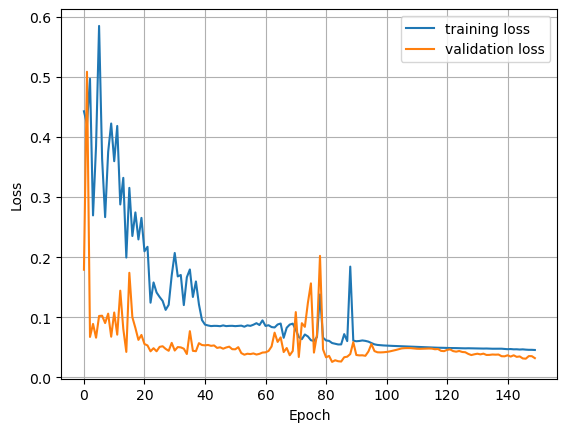

In [14]:
plt.plot(train_losses, label='training loss')
plt.plot(validation_losses, label='validation loss')
plt.legend();
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Cheking 

In [26]:
# Functions 
def CreatePointCloud(color_im, depth_im):
    color_raw = o3d.geometry.Image(color_im)
    depth_raw = o3d.geometry.Image(depth_im)
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw, 1000) # 
    PointCloud = o3d.geometry.PointCloud.create_from_rgbd_image(
      rgbd_image,o3d.camera.PinholeCameraIntrinsic(o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)) # Creates Point Cloud from rgbd image
#     PointCloud.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]) # Flip it, otherwise the pointcloud will be upside down
    return PointCloud

def pick_points(pcd):
    vis = o3d.visualization.VisualizerWithEditing()
    vis.create_window()
    vis.add_geometry(pcd)
    vis.run()
    vis.destroy_window()
    numpy_array=np.asarray(pcd.points)
    point_id=vis.get_picked_points()

    return [numpy_array[point_id[0]],numpy_array[point_id[1]]]

def draw_arrow(pcd, points_real, points_extimated):
    lines=[[0,1],[2,3]]
    points = np.concatenate((points_real, points_extimated), axis=0)
    colors = [[1,0,0],[0,0,1]] # Red is REAL and Green is ESTIMATED
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(points),
        lines=o3d.utility.Vector2iVector(lines),

    )
    line_set.colors=o3d.utility.Vector3dVector(colors)
    o3d.visualization.draw_geometries([pcd,line_set])

In [27]:
inv_resize = transforms.Resize(480, interpolation=transforms.InterpolationMode.NEAREST)

In [28]:
# Model = AoRNet()
Model.load_state_dict(torch.load('Modele/Small2_RN_150Epoch'))
Model.eval()

AoRNet(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [33]:
# torch.manual_seed(101)
diff_X1 = []
diff_Y1 = []
diff_Z1 = []
diff_X2 = []
diff_Y2 = []
diff_Z2 = []

X1 = [] 
Y1 = [] 
Z1 = []
X2 = []
Y2 = []
Z2 = [] 

hX1 = [] 
hY1 = [] 
hZ1 = []
hX2 = []
hY2 = []
hZ2 = [] 

with torch.no_grad():
    for b, (X_validation, y_validation) in enumerate(validation_loader):
#         Apply the model
        
        X_validation = X_validation.to(device)
        y_validation = y_validation.to(device)
        

        y_val = Model(X_validation)
#         print(y_val.shape)
        for j in range(y_val.shape[0]):
            X_invNorm = inv_resize(X_validation[j])
            RGB_buff = X_invNorm[0].cpu().numpy()*255
#             RGB_buff = np.stack((X_invNorm[0].numpy(),X_invNorm[1].numpy(),X_invNorm[2].numpy()))*255
#             RGB_buff = np.transpose(RGB_buff, (1,2,0))
            RGB_buff = np.ascontiguousarray(RGB_buff, dtype=np.uint8)

            DEPTH_buff = X_invNorm[1].cpu().numpy()*5500
            PC = CreatePointCloud(RGB_buff, DEPTH_buff)
            PREDICTED = [[y_val[j][0].cpu().numpy(), y_val[j][1].cpu().numpy(), y_val[j][2].cpu().numpy()],
                         [y_val[j][3].cpu().numpy(), y_val[j][4].cpu().numpy(), y_val[j][5].cpu().numpy()]]
            REAL = [[y_validation[j][0].cpu().numpy(), y_validation[j][1].cpu().numpy(), y_validation[j][2].cpu().numpy()],
                    [y_validation[j][3].cpu().numpy(), y_validation[j][4].cpu().numpy(), y_validation[j][5].cpu().numpy()]]
            draw_arrow(PC, REAL, PREDICTED)

            print(f'--> BATCH: {b+1} <-- | --> ROW: {j} <--')
            print(f'----------------------------------------------------------------------------------------------')
            print(f'{"X1":>12} {"Y1":>12} {"Z1":>12} {"X2":>12} {"Y2":>12} {"Z2":>12}')
            print(f'{"PREDICTED:"}')
            print(f'[[{y_val[j][0]:12.5f}, {y_val[j][1]:12.5f}, {y_val[j][2]:12.5f}], [{y_val[j][3]:12.5f}, {y_val[j][4]:12.5f}, {y_val[j][5]:12.5f}]]')
            print(f'{"REAL:"}')
            print(f'[[{y_validation[j][0]:12.5f}, {y_validation[j][1]:12.5f}, {y_validation[j][2]:12.5f}], [{y_validation[j][3]:12.5f}, {y_validation[j][4]:12.5f}, {y_validation[j][5]:12.5f}]]')
            print(f'{"DIFFERENCE:"}')
            diff = np.abs(y_val.cpu().numpy()-y_validation.cpu().numpy())
            print(f'[[{diff[j][0]:12.5f}, {diff[j][1]:12.5f}, {diff[j][2]:12.5f}], [{diff[j][3]:12.5f}, {diff[j][4]:12.5f}, {diff[j][5]:12.5f}]]')
            print(f'----------------------------------------------------------------------------------------------')
            diff_X1.append(diff[j][0])
            diff_Y1.append(diff[j][1])
            diff_Z1.append(diff[j][2])
            diff_X2.append(diff[j][3])
            diff_Y2.append(diff[j][4])
            diff_Z2.append(diff[j][5])
            
            X1.append(y_validation[j][0].cpu().numpy())
            Y1.append(y_validation[j][1].cpu().numpy())
            Z1.append(y_validation[j][2].cpu().numpy())
            X2.append(y_validation[j][3].cpu().numpy())
            Y2.append(y_validation[j][4].cpu().numpy())
            Z2.append(y_validation[j][5].cpu().numpy())

            hX1.append(y_val[j][0].cpu().numpy()) 
            hY1.append(y_val[j][1].cpu().numpy()) 
            hZ1.append(y_val[j][2].cpu().numpy())
            hX2.append(y_val[j][3].cpu().numpy())
            hY2.append(y_val[j][4].cpu().numpy())
            hZ2.append(y_val[j][5].cpu().numpy()) 
            

--> BATCH: 1 <-- | --> ROW: 0 <--
----------------------------------------------------------------------------------------------
          X1           Y1           Z1           X2           Y2           Z2
PREDICTED:
[[     0.06647,     -0.52906,      1.70012], [     0.07016,      0.51426,      1.80695]]
REAL:
[[     0.45473,     -0.58426,      1.51100], [     0.45519,      0.72499,      1.73800]]
DIFFERENCE:
[[     0.38826,      0.05520,      0.18912], [     0.38503,      0.21073,      0.06895]]
----------------------------------------------------------------------------------------------
--> BATCH: 1 <-- | --> ROW: 1 <--
----------------------------------------------------------------------------------------------
          X1           Y1           Z1           X2           Y2           Z2
PREDICTED:
[[     0.09591,     -0.51812,      1.74780], [     0.08962,      0.51914,      1.86796]]
REAL:
[[     0.45473,     -0.58426,      1.51100], [     0.45519,      0.72499,      1.73800]]


KeyboardInterrupt: 

In [30]:
# Save the model
# torch.save(Model.state_dict(), 'Modele/Big2_RN_150Epoch')

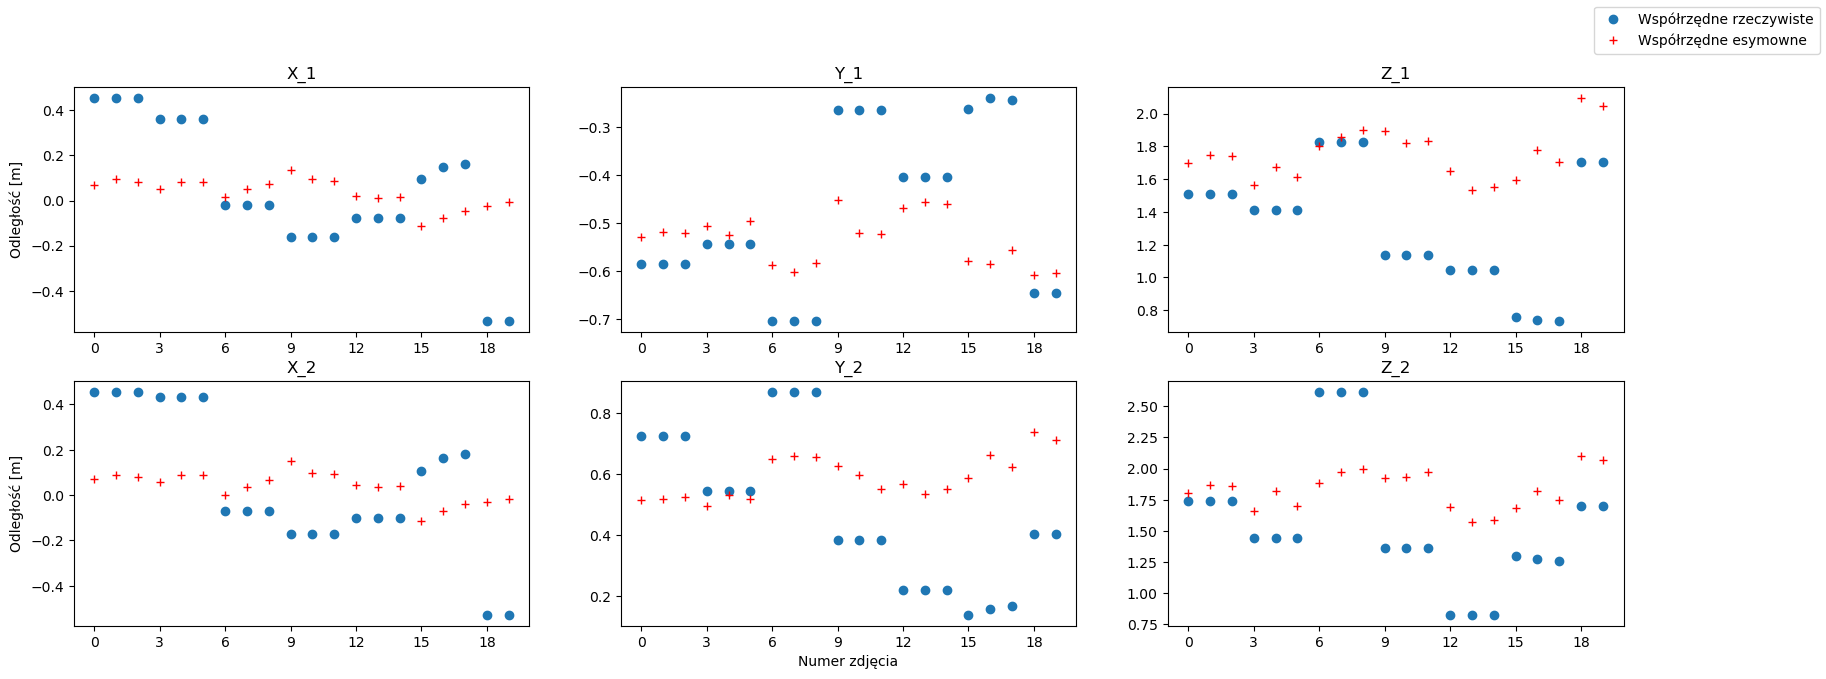

In [31]:
from matplotlib.ticker import MaxNLocator

fig, axs = plt.subplots(2, 3,figsize=(20,7))
axs[0, 0].plot(X1[0:20],'o')
axs[0, 0].plot(hX1[0:20],'+r')
axs[0, 0].set_title('X_1')
axs[0, 0].set(ylabel='Odległość [m]')

axs[0, 1].plot(Y1[0:20],'o')
axs[0, 1].plot(hY1[0:20],'+r')
axs[0, 1].set_title('Y_1')

axs[0, 2].plot(Z1[0:20],'o')
axs[0, 2].plot(hZ1[0:20],'+r')
axs[0, 2].set_title('Z_1')

axs[1, 0].plot(X2[0:20],'o')
axs[1, 0].plot(hX2[0:20],'+r')
axs[1, 0].set_title('X_2')
axs[1, 0].set(ylabel='Odległość [m]')

axs[1, 1].plot(Y2[0:20],'o')
axs[1, 1].plot(hY2[0:20],'+r')
axs[1, 1].set_title('Y_2')
axs[1, 1].set(xlabel='Numer zdjęcia')

axs[1, 2].plot(Z2[0:20],'o')
axs[1, 2].plot(hZ2[0:20],'+r')
axs[1, 2].set_title('Z_2')

for ax in axs.flat:
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# for ax in axs.flat:
#     ax.label_outer()

fig.legend(['Współrzędne rzeczywiste','Współrzędne esymowne'])

plt.show()
SAVE_DIR = '/home/el_zlociako/Documents/Praca_inzynierska/CNN/Ploty_do_inz/'
# fig.savefig(SAVE_DIR+'Small_REG_test.eps', format='eps')

In [32]:
X1_MEAN_DIFF = np.mean(diff_X1)
Y1_MEAN_DIFF = np.mean(diff_Y1)
Z1_MEAN_DIFF = np.mean(diff_Z1)
X2_MEAN_DIFF = np.mean(diff_X1)
Y2_MEAN_DIFF = np.mean(diff_Y2)
Z2_MEAN_DIFF = np.mean(diff_Z2)

MEAN_ERR = [X1_MEAN_DIFF, Y1_MEAN_DIFF, Z1_MEAN_DIFF, X2_MEAN_DIFF, Y2_MEAN_DIFF, Z2_MEAN_DIFF]
print(MEAN_ERR)

[0.27090982, 0.12706468, 0.45283493, 0.27090982, 0.2109709, 0.5147743]
